In [12]:
import numpy as np
import pandas as pd
np.set_printoptions(threshold=10000,suppress=True)
import warnings
import matplotlib
import matplotlib.pyplot as plt
import copy
import sklearn.neural_network as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
import seaborn as sns


In [4]:
class PMC:
    def __init__(self, n_classes, n_features, learning_rate=0.01):
        self.n_classes = n_classes
        self.n_features = n_features
        self.learning_rate = learning_rate
        self.early_stopper = 3
        self.converging = 0
        self.converging_threshold = 0.02
        self.weights = np.random.rand(n_classes, n_features)

    def fit(self, X, y):
        previous_weights = self.weights.copy()
        predictions = []
        for i in range(len(X)):
            prediction = self.predict(X[i])
            predictions.append(prediction)
            if prediction != y[i]:
                self.weights[prediction-1] -= self.learning_rate * X[i]
                self.weights[y[i]-1] += self.learning_rate * X[i]
        #compare weights to check if converged
        total_diff = 0.
        for i in range(len(self.weights)):
            total_diff += np.sum(np.abs(self.weights[i] - previous_weights[i]))
        if total_diff < self.converging_threshold:
            self.converging += 1
        else:
            self.converging = 0
        weights_equals = self.converging >= self.early_stopper
        return predictions, weights_equals
        
    def predict(self, X):
        scores = np.dot(self.weights, X)
        return np.argmax(scores)+1

    def score(self, X, y):
        correct = 0
        for i in range(len(X)):
            if self.predict(X[i]) == y[i]:
                correct += 1
        return correct / len(X)

In [41]:
def LoadAndProcess(path, n_features, sep =';', scaled = True):
    data = pd.read_csv(path, sep=sep)
    
    if scaled:
        scaler = StandardScaler()
        data.iloc[:, :n_features] = scaler.fit_transform(data.iloc[:, :n_features])
    
    x = data.iloc[:, :n_features].values
    y = data.iloc[:, n_features].values
    
    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.33)
    
    return X_train, X_test, y_train, y_test

def SplitAndSample(X, y):
    X_sample, y_sample = resample(X, y, n_samples=len(X)//2, replace=False)
    
    return X_sample, y_sample

In [20]:
def performance(y_test, y_pred):
    print("Precision: ", precision_score(y_test, y_pred, average='macro'))
    print("Recall: ", recall_score(y_test, y_pred, average='macro'))
    print("Accuracy: ", accuracy_score(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='g')

In [21]:
X_train, X_test, y_train, y_test = LoadAndProcess('iris.txt', 4, "\t", scaled=False)

In [22]:
pmc = PMC(3, 4)
converged = False
max_iters = 5000
iters = 0
predictions = []

while not converged and iters < max_iters :
    predictions, converged = pmc.fit(X_train, y_train)
    iters += 1
print("Converged in " + str(iters) + " iterations")

Converged in 5000 iterations


Precision:  0.9588867805186592
Recall:  0.9588867805186592
Accuracy:  0.9595959595959596


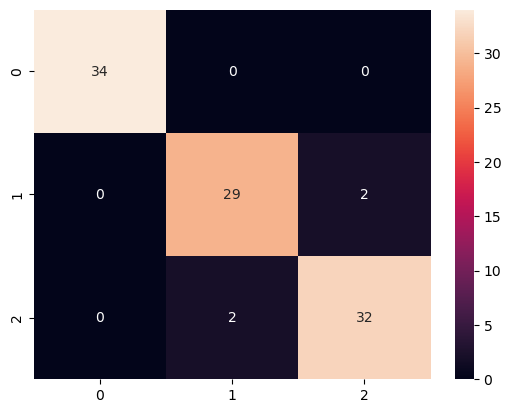

In [23]:
performance(y_train, predictions)

Precision:  0.9333333333333332
Recall:  0.9298245614035089
Accuracy:  0.92


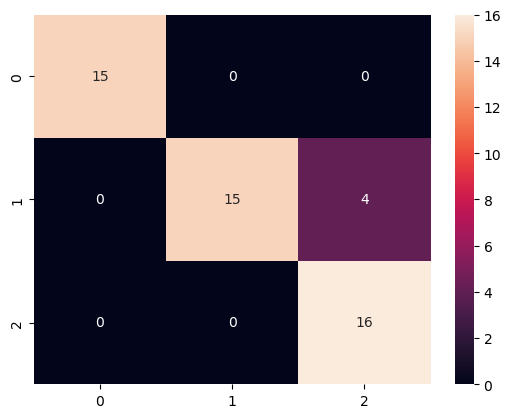

In [24]:
performance(y_test, [pmc.predict(x) for x in X_test])

In [26]:
mlp = nn.MLPClassifier(
    hidden_layer_sizes=(3), activation='relu', solver='adam', random_state=2,
    learning_rate='adaptive', learning_rate_init=0.01, max_iter=2000)

mlp.fit(X_train, y_train)

MLPClassifier(hidden_layer_sizes=3, learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=2000, random_state=2)

/home/duskel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.11447811447811447
Recall:  0.3333333333333333
Accuracy:  0.3434343434343434


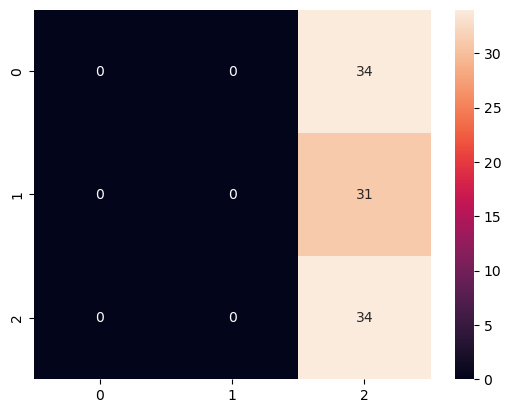

In [27]:
performance(y_train, mlp.predict(X_train))

/home/duskel/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision:  0.10666666666666667
Recall:  0.3333333333333333
Accuracy:  0.32


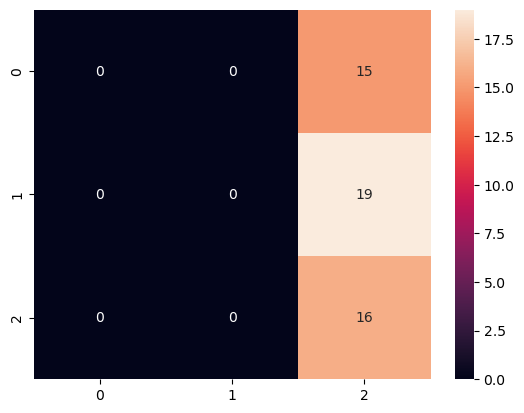

In [29]:
performance(y_test, mlp.predict(X_test))

In [30]:
Xtr_scaled, Xt_scaled, ytr_scaled, yt_scaled = LoadAndProcess('iris.txt', 4, "\t", scaled=True)

In [31]:
mlp = nn.MLPClassifier(
    hidden_layer_sizes=(3), activation='relu', solver='adam', random_state=2,
    learning_rate='adaptive', learning_rate_init=0.01, max_iter=2000)

mlp.fit(Xtr_scaled, ytr_scaled)

MLPClassifier(hidden_layer_sizes=3, learning_rate='adaptive',
              learning_rate_init=0.01, max_iter=2000, random_state=2)

Precision:  0.9895833333333334
Recall:  0.9904761904761905
Accuracy:  0.98989898989899


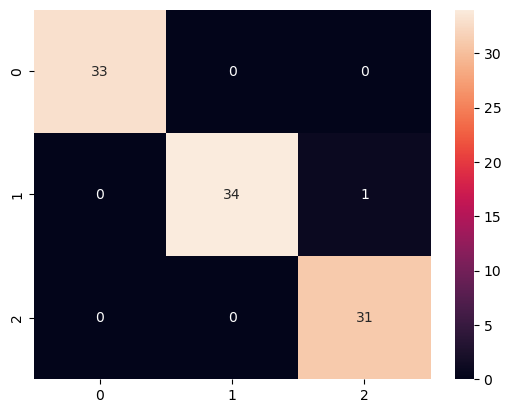

In [32]:
performance(ytr_scaled, mlp.predict(Xtr_scaled))

Precision:  0.9791666666666666
Recall:  0.9824561403508771
Accuracy:  0.98


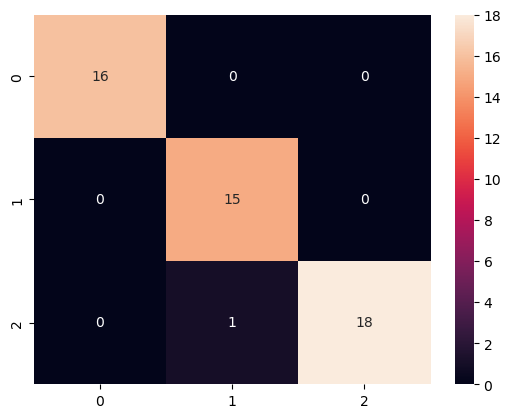

In [33]:
performance(yt_scaled, mlp.predict(Xt_scaled))

In [42]:
class Bagging:
    def __init__(self, k = 5):
        self.k = k
        self.models = [nn.MLPClassifier(hidden_layer_sizes=(3), learning_rate='adaptive', learning_rate_init = 0.01, random_state=2, max_iter=2000) for i in range(k)]
    
    def train(self, X, y):
        for i in range(self.k):
            self.models[i].fit(X[i], y[i])
            
    def predict(self, X):
        predictions = []
        for i in range(self.k):
            predictions.append(self.models[i].predict(X))
        
        return np.array(predictions).T

    def choose_prediction(self, X):
        predictions = self.predict(X)
        return np.array([np.argmax(np.bincount(predictions[i])) for i in range(len(predictions))])
    

In [44]:
X_s, y_s = [], []
for i in range(3):
    sample = SplitAndSample(X_train, y_train)
    X_s.append(sample[0])
    y_s.append(sample[1])

bagging = Bagging(3)
bagging.train(X_s, y_s)
test_predictions = bagging.choose_prediction(X_test)

ValueError: Found array with dim 3. MLPClassifier expected <= 2.

In [ ]:
perform